In [1]:
%cd /content/drive/MyDrive/NLP/semevaltask9

/content/drive/MyDrive/NLP/semevaltask9


In [2]:
! pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.2 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import pandas as pd
import random
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, RobertaForMultipleChoice

In [4]:
GLOBAL_SEED = 255

np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
torch.use_deterministic_algorithms(True)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Baselines:

## Import train and test dataset

In [6]:
data = np.load("./Data/SP_train.npy", allow_pickle = True ).tolist()
SP_train = pd.DataFrame(data)
data = np.load("./Data/SP_test.npy", allow_pickle = True ).tolist()
SP_test = pd.DataFrame(data)
data = np.load("./Data/SP_test_answer.npy", allow_pickle = True ).tolist()
SP_test_answer = pd.DataFrame(data)

data = np.load("./Data/WP_train.npy", allow_pickle = True ).tolist()
WP_train = pd.DataFrame(data)
data = np.load("./Data/WP_test.npy", allow_pickle = True ).tolist()
WP_test = pd.DataFrame(data)
data = np.load("./Data/WP_test_answer.npy", allow_pickle = True ).tolist()
WP_test_answer = pd.DataFrame(data)

data = np.load("./Data/sentence_puzzle.npy", allow_pickle = True ).tolist()
SP = pd.DataFrame(data)
data = np.load("./Data/word_puzzle.npy", allow_pickle = True ).tolist()
WP = pd.DataFrame(data)

In [ ]:
SP_test

,question,choice_list
0,"In a small village, two farmers are working in...","[The lazy farmer is his mother., The lazy farm..."
1,Romeo and Juliet are discovered dead on the be...,[They were sleeping and scared by the sound of...
2,How many years in your life it happens that be...,"[In ech leap year., In the first year of gradu..."
3,Who would serve as the team's captain if a cru...,"[The first officer., The captain., The second ..."
4,"In one city, 5% of the population has an unlis...","[One hundred people., Ninty-five people., Five..."
...,...,...
115,A professional fisherman caught 30 fish during...,"[Two., One., Three., None of above.]"
116,Bob was working on a project when suddenly int...,"[He needed a membership to search in google., ..."
117,"He has wed numerous women, but never himself. ...","[A teacher., A preacher., A laywer., None of a..."
118,You walk into a room and see a bed and lie on ...,"[Thirty-six, as there are eighteen animals., S..."


In [7]:
for index, row in SP_test.iterrows():
  SP_test.at[index, 'label'] = int(SP_test_answer.loc[index][1])

In [8]:
for index, row in WP_test.iterrows():
  WP_test.at[index, 'label'] = int(WP_test_answer.loc[index][1])

## Dataset Class

In [9]:
# Define a custom dataset class for multiple-choice questions
class BrainTeaser(Dataset):
    def __init__(self, data, tokenizer, max_length = 512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        df = self.data.iloc[idx]

        choices = df['choice_list']

        question = df['question']

        true_label = df['label']

        # Tokenize the inputs
        tokenized_inputs = tokenizer([question, question, question, question], [choices[0], choices[1], choices[2], choices[3]], return_tensors='pt', padding='max_length', max_length=self.max_length)

        return {
            'input_ids': tokenized_inputs['input_ids'],
            'attention_mask': tokenized_inputs['attention_mask'],
            'labels': torch.tensor(true_label, dtype=torch.long)
        }

# Import RoBERTa Large

In [10]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = RobertaForMultipleChoice.from_pretrained("roberta-large", device_map = 'auto')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Define a function to perform inference
def inference(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Choose the predicted label (choice with the highest logit)
            predicted_labels = torch.argmax(logits, dim=1).tolist()
            predictions.extend(predicted_labels)

    return predictions

In [ ]:
# create dataloaders
sp_test_dataset = BrainTeaser(SP_test, tokenizer)
wp_test_dataset = BrainTeaser(WP_test, tokenizer)

In [ ]:
# Create a DataLoader for evaluation
sp_test_dataloader = DataLoader(sp_test_dataset, batch_size=1)
wp_test_dataloader = DataLoader(wp_test_dataset, batch_size=1)

In [ ]:
# Perform inference
predictions = inference(model, sp_test_dataloader)
accuracy = 100 * accuracy_score([int(label) for label in SP_test_answer[1].tolist()], predictions)

print("SP:", accuracy)

SP: 23.333333333333332


In [ ]:
for pred in predictions:
  print(pred)

3
3
3
3
1
2
2
1
0
0
3
3
0
1
0
1
0
0
0
0
0
2
1
3
0
2
0
3
2
1
2
3
2
2
1
0
0
2
1
3
2
2
2
3
1
0
2
0
0
0
3
1
1
1
3
1
0
1
2
2
2
0
3
0
2
2
3
1
1
1
0
0
0
1
0
1
1
1
3
0
1
0
2
1
2
0
2
0
0
2
1
1
1
3
3
2
2
0
2
2
0
2
3
3
0
3
2
0
1
1
0
0
0
1
0
1
2
2
3
3


In [ ]:
# Perform inference
predictions = inference(model, wp_test_dataloader)
accuracy = 100 * accuracy_score([int(label) for label in WP_test_answer[1].tolist()], predictions)

print("WP:", accuracy)

WP: 29.166666666666668


In [ ]:
for pred in predictions:
  print(pred)

2
1
1
3
2
1
0
1
1
2
1
2
1
1
3
0
2
2
0
1
0
1
1
0
2
0
2
2
0
2
0
0
2
2
2
3
1
0
2
1
2
3
1
2
2
1
1
0
2
0
2
2
0
0
2
2
0
1
0
3
2
1
3
1
2
0
1
2
2
2
2
0
3
0
0
3
1
1
0
1
0
0
2
0
2
1
3
3
3
1
0
2
0
2
2
0


## Training


###SP

In [ ]:
# create datasets
sp_train_dataset = BrainTeaser(SP_train, tokenizer)
sp_test_dataset = BrainTeaser(SP_test, tokenizer)

In [ ]:
epochs = 2
batch = 1
weight_decay= 0.01
logging_steps = 100
lr = 1e-5

In [ ]:
from transformers import TrainingArguments, Trainer

%cd /content/

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=epochs,              # total number of training epochs
    per_device_train_batch_size=batch,  # batch size per device during training
    learning_rate = lr,
    weight_decay=weight_decay,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=logging_steps,
    evaluation_strategy = "steps",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

# Create a function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).astype(np.float32).mean().item()}

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=sp_train_dataset,
    eval_dataset=sp_test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


/content


Step,Training Loss,Validation Loss,Accuracy
100,1.461000,1.353670,0.375000
200,1.314800,1.226840,0.558333
300,0.912100,0.985992,0.666667
400,0.646500,0.873504,0.675000
500,0.536300,0.924780,0.700000
600,0.417200,0.755931,0.783333
700,0.301100,0.959063,0.758333
800,0.496100,0.939503,0.775000
900,0.488400,1.007900,0.758333
1000,0.263600,0.928834,0.766667


TrainOutput(global_step=1014, training_loss=0.6840065705940803, metrics={'train_runtime': 1830.7119, 'train_samples_per_second': 0.554, 'train_steps_per_second': 0.554, 'total_flos': 3779900838125568.0, 'train_loss': 0.6840065705940803, 'epoch': 2.0})

### Predict labels

In [ ]:
# Evaluate the model on the test data
predictions_output = trainer.predict(sp_test_dataset)

# Get the predictions
predictions = predictions_output.predictions

predicted_classes = np.argmax(predictions, axis=1)

# Now, predicted_classes is a list of predictions for the test data
print(predicted_classes)

[0 2 2 3 3 0 0 3 3 1 1 0 2 0 1 1 0 2 2 3 0 1 1 0 3 2 0 2 2 2 3 2 2 2 2 2 3
 0 0 0 1 1 0 3 3 2 2 2 0 2 0 0 3 1 2 0 2 1 1 1 3 1 1 1 3 2 2 1 2 0 0 0 2 2
 1 2 3 0 1 0 1 2 3 0 2 1 3 2 3 2 3 0 3 0 2 3 1 2 3 2 1 1 0 2 2 2 3 3 3 3 1
 3 1 3 2 3 2 3 1 3]


### WP

In [11]:
# create datasets
wp_train_dataset = BrainTeaser(WP_train, tokenizer)
wp_test_dataset = BrainTeaser(WP_test, tokenizer)

In [12]:
epochs = 2
batch = 1
weight_decay= 0.01
logging_steps = 100
lr = 1e-5

In [13]:
from transformers import TrainingArguments, Trainer

%cd /content/

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=epochs,              # total number of training epochs
    per_device_train_batch_size=batch,  # batch size per device during training
    learning_rate = lr,
    weight_decay=weight_decay,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=logging_steps,
    evaluation_strategy = "steps",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

# Create a function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).astype(np.float32).mean().item()}

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=wp_train_dataset,
    eval_dataset=wp_test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


/content


Step,Training Loss,Validation Loss,Accuracy
100,1.351200,1.327090,0.302083
200,1.340500,1.112263,0.458333
300,1.153300,0.975618,0.604167
400,1.141800,1.031461,0.572917
500,0.881000,1.483241,0.437500
600,0.861100,1.575109,0.645833
700,0.743900,1.787484,0.625000


TrainOutput(global_step=792, training_loss=1.018087680893715, metrics={'train_runtime': 1285.6502, 'train_samples_per_second': 0.616, 'train_steps_per_second': 0.616, 'total_flos': 2952348583624704.0, 'train_loss': 1.018087680893715, 'epoch': 2.0})

In [17]:
# Evaluate the model on the test data
predictions_output = trainer.predict(wp_test_dataset)

# Get the predictions
predictions = predictions_output.predictions

predicted_classes = np.argmax(predictions, axis=1)

# Now, predicted_classes is a list of predictions for the test data
print(predicted_classes)

[1 2 0 1 1 1 2 1 1 2 1 2 0 1 2 1 0 0 0 1 0 1 0 0 2 1 0 1 0 2 1 0 2 0 2 2 0
 1 0 2 1 0 2 0 2 1 0 1 1 0 1 2 2 0 2 1 2 0 0 1 1 1 1 1 2 1 2 0 0 2 1 0 0 2
 0 2 2 2 2 0 0 1 0 0 0 1 0 3 3 0 2 1 2 2 2 0]


In [19]:
correct = 0.0
for index in range(96):
  if predicted_classes[index] == wp_test_dataset[index]['labels']:
    correct+=1
print(correct/96)

0.6458333333333334


In [20]:
for pred in predicted_classes:
  print(pred)

1
2
0
1
1
1
2
1
1
2
1
2
0
1
2
1
0
0
0
1
0
1
0
0
2
1
0
1
0
2
1
0
2
0
2
2
0
1
0
2
1
0
2
0
2
1
0
1
1
0
1
2
2
0
2
1
2
0
0
1
1
1
1
1
2
1
2
0
0
2
1
0
0
2
0
2
2
2
2
0
0
1
0
0
0
1
0
3
3
0
2
1
2
2
2
0


# Draw Plots

### SP

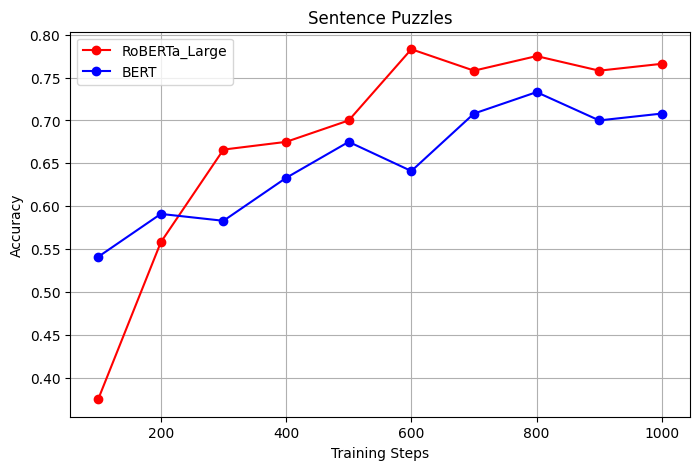

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for RoBERTa_Large
steps_roberta = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
accuracy_roberta = np.array([0.375, 0.558, 0.666, 0.675, 0.700, 0.783, 0.758, 0.775, 0.758, 0.766])

# Data for BERT
steps_bert = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
accuracy_bert = np.array([0.541, 0.591, 0.583, 0.633, 0.675, 0.641, 0.708, 0.733, 0.700, 0.708])

# Create the plot
plt.figure(figsize=(8,5))

# Plot lines
plt.plot(steps_roberta, accuracy_roberta, 'ro-', label='RoBERTa_Large')
plt.plot(steps_bert, accuracy_bert, 'bo-', label='BERT')

# Add title and labels to axes
plt.title('Sentence Puzzles')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')

# Show legend to identify each line
plt.legend()

# Display the plot
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('finetuned_sp.png')

# Show the plot
plt.show()


### WP

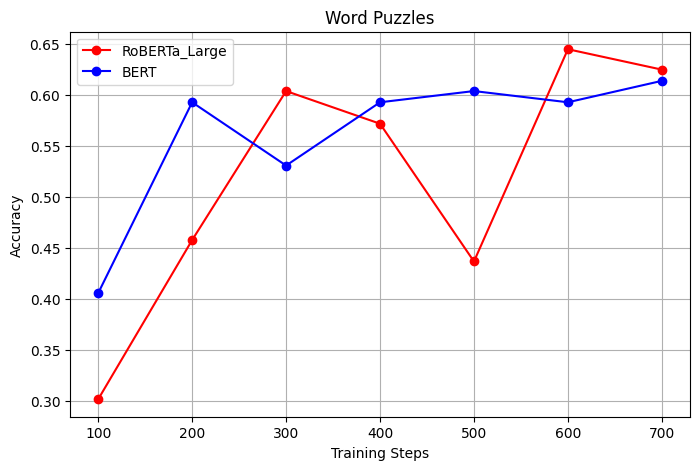

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for RoBERTa_Large
steps_roberta = np.array([100, 200, 300, 400, 500, 600, 700])
accuracy_roberta = np.array([0.302, 0.458, 0.604, 0.572, 0.437, 0.645, 0.625])

# Data for BERT
steps_bert = np.array([100, 200, 300, 400, 500, 600, 700])
accuracy_bert = np.array([0.406, 0.593, 0.531, 0.593, 0.604, 0.593, 0.614])

# Create the plot
plt.figure(figsize=(8,5))

# Plot lines
plt.plot(steps_roberta, accuracy_roberta, 'ro-', label='RoBERTa_Large')
plt.plot(steps_bert, accuracy_bert, 'bo-', label='BERT')

# Add title and labels to axes
plt.title('Word Puzzles')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')

# Show legend to identify each line
plt.legend()

# Display the plot
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('finetuned_wp.png')

# Show the plot
plt.show()
